# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

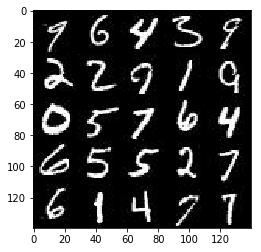

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

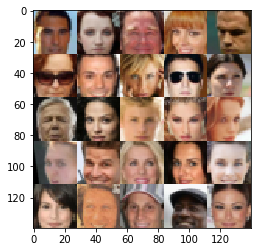

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=[])    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=.2, drop_rate=.8 ): 
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: How leaky relu is
    :param drop_rate: Dropout rate (higher is more conservative)
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, 
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, 
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        
        x3 = tf.layers.conv2d(relu2, 224, 5, strides=2, 
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        
    
        x4 = tf.layers.conv2d(relu3, 448, 5, strides=2, 
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
            

        # Flatten it
        flat = tf.reshape(relu4, (-1, 4*4*448))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
       
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: How leaky relu is
    :return: The tensor output of the generator
    """
    
    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        
        x0 = tf.layers.dense(z, 4*4*448)
        # Reshape it to start the convolutional stack
        x0 = tf.reshape(x0, (-1, 4, 4, 448))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)
        
 
        # Reshape it to start the convolutional stack
        x1 = tf.layers.conv2d_transpose(x0, 224, 4, strides=1, 
                                        padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 112, 5, strides=2, 
                                        padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
       
        
        x3 = tf.layers.conv2d_transpose(x2, 56, 5, strides=2, 
                                        padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, 
                                            padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())

        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=.2, smooth=.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :alpha: How leaky relu is
    :smooth: Amount to subtract for label smoothing
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1.0 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
        
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z,
                                              data_shape[3], alpha=.2)
    
    
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0 #For counting batches
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers - Running generator 3 times, discriminator twice (not sure if implemented correctly?)
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
    
                
                if steps % 10 == 0:  #Print output every 10
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:   #Show example every 100
                    show_generator_output(sess, 25, input_z, data_shape[3], image_mode=data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 1.1840
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 1.2493
Epoch 1/2... Discriminator Loss: 1.8396... Generator Loss: 0.3081
Epoch 1/2... Discriminator Loss: 1.9920... Generator Loss: 0.2826
Epoch 1/2... Discriminator Loss: 2.3400... Generator Loss: 0.2007
Epoch 1/2... Discriminator Loss: 2.0295... Generator Loss: 0.2427
Epoch 1/2... Discriminator Loss: 2.5419... Generator Loss: 0.1368
Epoch 1/2... Discriminator Loss: 2.3298... Generator Loss: 0.1742
Epoch 1/2... Discriminator Loss: 2.6611... Generator Loss: 0.1153
Epoch 1/2... Discriminator Loss: 2.5359... Generator Loss: 0.1293


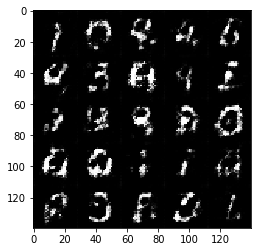

Epoch 1/2... Discriminator Loss: 2.4775... Generator Loss: 0.1448
Epoch 1/2... Discriminator Loss: 2.3786... Generator Loss: 0.1629
Epoch 1/2... Discriminator Loss: 2.5444... Generator Loss: 0.1344
Epoch 1/2... Discriminator Loss: 2.1574... Generator Loss: 0.2343
Epoch 1/2... Discriminator Loss: 2.1559... Generator Loss: 0.2208
Epoch 1/2... Discriminator Loss: 2.0258... Generator Loss: 0.2315
Epoch 1/2... Discriminator Loss: 1.9811... Generator Loss: 0.2749
Epoch 1/2... Discriminator Loss: 2.2450... Generator Loss: 0.1953
Epoch 1/2... Discriminator Loss: 2.0650... Generator Loss: 0.2432
Epoch 1/2... Discriminator Loss: 1.9490... Generator Loss: 0.2643


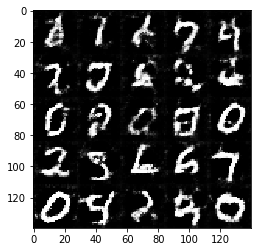

Epoch 1/2... Discriminator Loss: 2.4187... Generator Loss: 0.1419
Epoch 1/2... Discriminator Loss: 1.7804... Generator Loss: 0.3315
Epoch 1/2... Discriminator Loss: 2.1793... Generator Loss: 0.1929
Epoch 1/2... Discriminator Loss: 1.8842... Generator Loss: 0.2761
Epoch 1/2... Discriminator Loss: 1.8438... Generator Loss: 0.2852
Epoch 1/2... Discriminator Loss: 1.7832... Generator Loss: 0.3404
Epoch 1/2... Discriminator Loss: 2.3342... Generator Loss: 0.1630
Epoch 1/2... Discriminator Loss: 1.8695... Generator Loss: 0.2749
Epoch 1/2... Discriminator Loss: 1.8331... Generator Loss: 0.2989
Epoch 1/2... Discriminator Loss: 2.0048... Generator Loss: 0.2347


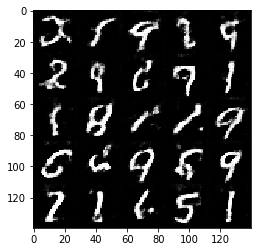

Epoch 1/2... Discriminator Loss: 1.5870... Generator Loss: 0.4304
Epoch 1/2... Discriminator Loss: 2.1771... Generator Loss: 0.1950
Epoch 1/2... Discriminator Loss: 1.6938... Generator Loss: 0.3896
Epoch 1/2... Discriminator Loss: 1.7408... Generator Loss: 0.3246
Epoch 1/2... Discriminator Loss: 1.8093... Generator Loss: 0.3035
Epoch 1/2... Discriminator Loss: 2.1336... Generator Loss: 0.2068
Epoch 1/2... Discriminator Loss: 1.8437... Generator Loss: 0.2750
Epoch 1/2... Discriminator Loss: 1.8646... Generator Loss: 0.2610
Epoch 1/2... Discriminator Loss: 1.8413... Generator Loss: 0.2887
Epoch 1/2... Discriminator Loss: 2.1804... Generator Loss: 0.1958


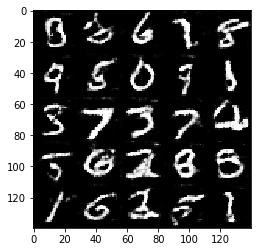

Epoch 1/2... Discriminator Loss: 2.3518... Generator Loss: 0.1688
Epoch 1/2... Discriminator Loss: 1.6650... Generator Loss: 0.3580
Epoch 1/2... Discriminator Loss: 2.0381... Generator Loss: 0.2387
Epoch 1/2... Discriminator Loss: 1.7939... Generator Loss: 0.3138
Epoch 1/2... Discriminator Loss: 1.6714... Generator Loss: 0.3608
Epoch 1/2... Discriminator Loss: 1.7532... Generator Loss: 0.3775
Epoch 2/2... Discriminator Loss: 1.9859... Generator Loss: 0.2480
Epoch 2/2... Discriminator Loss: 2.3609... Generator Loss: 0.1634
Epoch 2/2... Discriminator Loss: 1.9907... Generator Loss: 0.2567
Epoch 2/2... Discriminator Loss: 2.2705... Generator Loss: 0.1734


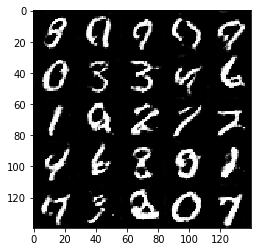

Epoch 2/2... Discriminator Loss: 2.2347... Generator Loss: 0.1811
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.5902
Epoch 2/2... Discriminator Loss: 1.9953... Generator Loss: 0.2449
Epoch 2/2... Discriminator Loss: 2.0016... Generator Loss: 0.2268
Epoch 2/2... Discriminator Loss: 1.5449... Generator Loss: 0.4077
Epoch 2/2... Discriminator Loss: 1.5266... Generator Loss: 0.4266
Epoch 2/2... Discriminator Loss: 1.8339... Generator Loss: 0.3049
Epoch 2/2... Discriminator Loss: 1.6959... Generator Loss: 0.3505
Epoch 2/2... Discriminator Loss: 1.8772... Generator Loss: 0.2883
Epoch 2/2... Discriminator Loss: 1.9529... Generator Loss: 0.2486


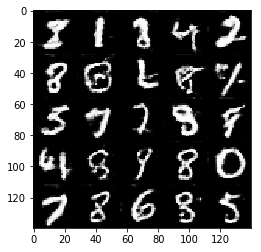

Epoch 2/2... Discriminator Loss: 2.1150... Generator Loss: 0.2097
Epoch 2/2... Discriminator Loss: 1.9432... Generator Loss: 0.2462
Epoch 2/2... Discriminator Loss: 2.1621... Generator Loss: 0.2111
Epoch 2/2... Discriminator Loss: 1.7694... Generator Loss: 0.2935
Epoch 2/2... Discriminator Loss: 2.1830... Generator Loss: 0.1934
Epoch 2/2... Discriminator Loss: 1.8106... Generator Loss: 0.3028
Epoch 2/2... Discriminator Loss: 1.8578... Generator Loss: 0.2826
Epoch 2/2... Discriminator Loss: 1.8050... Generator Loss: 0.3069
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 0.7827
Epoch 2/2... Discriminator Loss: 1.8902... Generator Loss: 0.2875


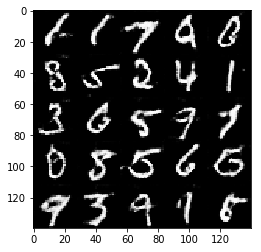

Epoch 2/2... Discriminator Loss: 2.0273... Generator Loss: 0.2303
Epoch 2/2... Discriminator Loss: 1.8520... Generator Loss: 0.3026
Epoch 2/2... Discriminator Loss: 1.9899... Generator Loss: 0.2493
Epoch 2/2... Discriminator Loss: 1.5736... Generator Loss: 0.3771
Epoch 2/2... Discriminator Loss: 1.5544... Generator Loss: 0.4453
Epoch 2/2... Discriminator Loss: 1.8727... Generator Loss: 0.2824
Epoch 2/2... Discriminator Loss: 2.3518... Generator Loss: 0.1628
Epoch 2/2... Discriminator Loss: 2.6588... Generator Loss: 0.1306
Epoch 2/2... Discriminator Loss: 2.3832... Generator Loss: 0.1655
Epoch 2/2... Discriminator Loss: 2.6095... Generator Loss: 0.1256


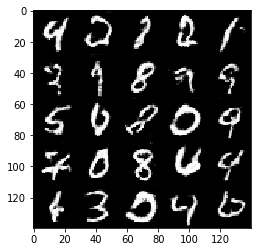

Epoch 2/2... Discriminator Loss: 1.7974... Generator Loss: 0.3068
Epoch 2/2... Discriminator Loss: 2.5660... Generator Loss: 0.1348
Epoch 2/2... Discriminator Loss: 2.1012... Generator Loss: 0.2139
Epoch 2/2... Discriminator Loss: 2.0921... Generator Loss: 0.2302
Epoch 2/2... Discriminator Loss: 1.5572... Generator Loss: 0.4289
Epoch 2/2... Discriminator Loss: 1.5896... Generator Loss: 0.3699
Epoch 2/2... Discriminator Loss: 1.5787... Generator Loss: 0.4195
Epoch 2/2... Discriminator Loss: 1.1465... Generator Loss: 1.0830
Epoch 2/2... Discriminator Loss: 1.9030... Generator Loss: 0.2745
Epoch 2/2... Discriminator Loss: 2.1807... Generator Loss: 0.2063


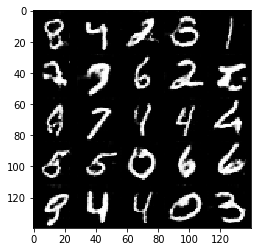

Epoch 2/2... Discriminator Loss: 2.2663... Generator Loss: 0.1827
Epoch 2/2... Discriminator Loss: 2.1455... Generator Loss: 0.2120
Epoch 2/2... Discriminator Loss: 1.7045... Generator Loss: 0.3202


In [12]:
batch_size = 128
z_dim = 64
learning_rate = .0004
beta1 = .5

# In the paper they used  
# Weight initialization from Zero-centered normal with std of .02

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.4995... Generator Loss: 0.0026
Epoch 1/1... Discriminator Loss: 2.7927... Generator Loss: 0.1066
Epoch 1/1... Discriminator Loss: 5.0381... Generator Loss: 0.0120
Epoch 1/1... Discriminator Loss: 4.4910... Generator Loss: 0.0173
Epoch 1/1... Discriminator Loss: 3.6379... Generator Loss: 0.0414
Epoch 1/1... Discriminator Loss: 3.3074... Generator Loss: 0.0578
Epoch 1/1... Discriminator Loss: 2.8583... Generator Loss: 0.1243
Epoch 1/1... Discriminator Loss: 3.5180... Generator Loss: 0.0497
Epoch 1/1... Discriminator Loss: 2.7251... Generator Loss: 0.1180
Epoch 1/1... Discriminator Loss: 2.9215... Generator Loss: 0.1045


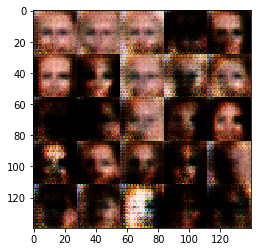

Epoch 1/1... Discriminator Loss: 3.0421... Generator Loss: 0.0948
Epoch 1/1... Discriminator Loss: 2.8006... Generator Loss: 0.1081
Epoch 1/1... Discriminator Loss: 2.4789... Generator Loss: 0.1364
Epoch 1/1... Discriminator Loss: 3.0478... Generator Loss: 0.1040
Epoch 1/1... Discriminator Loss: 2.9918... Generator Loss: 0.0906
Epoch 1/1... Discriminator Loss: 2.7242... Generator Loss: 0.1271
Epoch 1/1... Discriminator Loss: 2.5239... Generator Loss: 0.1373
Epoch 1/1... Discriminator Loss: 2.6693... Generator Loss: 0.1181
Epoch 1/1... Discriminator Loss: 2.5309... Generator Loss: 0.1445
Epoch 1/1... Discriminator Loss: 2.1387... Generator Loss: 0.2190


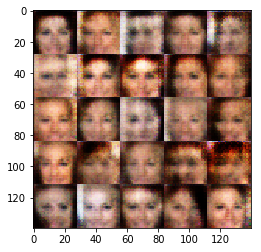

Epoch 1/1... Discriminator Loss: 2.1832... Generator Loss: 0.2104
Epoch 1/1... Discriminator Loss: 2.3472... Generator Loss: 0.1785
Epoch 1/1... Discriminator Loss: 2.6139... Generator Loss: 0.1371
Epoch 1/1... Discriminator Loss: 2.2747... Generator Loss: 0.1749
Epoch 1/1... Discriminator Loss: 2.5281... Generator Loss: 0.1405
Epoch 1/1... Discriminator Loss: 2.4744... Generator Loss: 0.1600
Epoch 1/1... Discriminator Loss: 2.2700... Generator Loss: 0.1702
Epoch 1/1... Discriminator Loss: 2.7255... Generator Loss: 0.1246
Epoch 1/1... Discriminator Loss: 2.3373... Generator Loss: 0.1921
Epoch 1/1... Discriminator Loss: 2.3667... Generator Loss: 0.1843


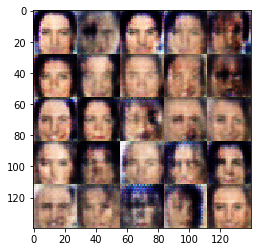

Epoch 1/1... Discriminator Loss: 2.0192... Generator Loss: 0.2442
Epoch 1/1... Discriminator Loss: 2.8108... Generator Loss: 0.1128
Epoch 1/1... Discriminator Loss: 2.2343... Generator Loss: 0.1994
Epoch 1/1... Discriminator Loss: 2.4057... Generator Loss: 0.1492
Epoch 1/1... Discriminator Loss: 2.3757... Generator Loss: 0.1692
Epoch 1/1... Discriminator Loss: 2.7118... Generator Loss: 0.1220
Epoch 1/1... Discriminator Loss: 2.5630... Generator Loss: 0.1387
Epoch 1/1... Discriminator Loss: 2.6672... Generator Loss: 0.1172
Epoch 1/1... Discriminator Loss: 2.4869... Generator Loss: 0.1475
Epoch 1/1... Discriminator Loss: 2.5343... Generator Loss: 0.1448


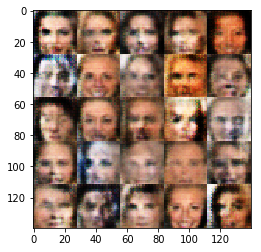

Epoch 1/1... Discriminator Loss: 2.4455... Generator Loss: 0.1511
Epoch 1/1... Discriminator Loss: 3.1057... Generator Loss: 0.0713
Epoch 1/1... Discriminator Loss: 2.3844... Generator Loss: 0.1732
Epoch 1/1... Discriminator Loss: 2.2307... Generator Loss: 0.2136
Epoch 1/1... Discriminator Loss: 2.0449... Generator Loss: 0.2474
Epoch 1/1... Discriminator Loss: 2.2078... Generator Loss: 0.2112
Epoch 1/1... Discriminator Loss: 2.4790... Generator Loss: 0.1485
Epoch 1/1... Discriminator Loss: 2.7990... Generator Loss: 0.1086
Epoch 1/1... Discriminator Loss: 2.1371... Generator Loss: 0.2321
Epoch 1/1... Discriminator Loss: 2.4084... Generator Loss: 0.1632


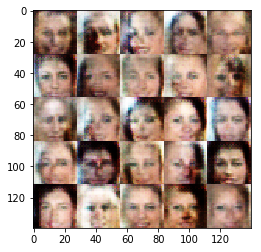

Epoch 1/1... Discriminator Loss: 2.8860... Generator Loss: 0.0954
Epoch 1/1... Discriminator Loss: 2.3189... Generator Loss: 0.1782
Epoch 1/1... Discriminator Loss: 2.2038... Generator Loss: 0.2296
Epoch 1/1... Discriminator Loss: 2.3459... Generator Loss: 0.1730
Epoch 1/1... Discriminator Loss: 2.7482... Generator Loss: 0.1244
Epoch 1/1... Discriminator Loss: 2.5902... Generator Loss: 0.1308
Epoch 1/1... Discriminator Loss: 2.5462... Generator Loss: 0.1304
Epoch 1/1... Discriminator Loss: 2.4733... Generator Loss: 0.1467
Epoch 1/1... Discriminator Loss: 2.5747... Generator Loss: 0.1414
Epoch 1/1... Discriminator Loss: 2.5245... Generator Loss: 0.1336


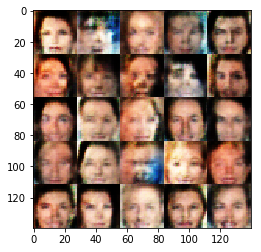

Epoch 1/1... Discriminator Loss: 2.5449... Generator Loss: 0.1545
Epoch 1/1... Discriminator Loss: 2.3979... Generator Loss: 0.1633
Epoch 1/1... Discriminator Loss: 2.8850... Generator Loss: 0.0878
Epoch 1/1... Discriminator Loss: 2.7866... Generator Loss: 0.1066
Epoch 1/1... Discriminator Loss: 2.3310... Generator Loss: 0.1663
Epoch 1/1... Discriminator Loss: 2.3862... Generator Loss: 0.1566
Epoch 1/1... Discriminator Loss: 2.8858... Generator Loss: 0.1017
Epoch 1/1... Discriminator Loss: 2.3642... Generator Loss: 0.1727
Epoch 1/1... Discriminator Loss: 2.1160... Generator Loss: 0.2296
Epoch 1/1... Discriminator Loss: 2.4980... Generator Loss: 0.1470


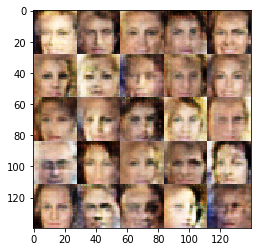

Epoch 1/1... Discriminator Loss: 2.4858... Generator Loss: 0.1580
Epoch 1/1... Discriminator Loss: 2.5265... Generator Loss: 0.1327
Epoch 1/1... Discriminator Loss: 2.5914... Generator Loss: 0.1392
Epoch 1/1... Discriminator Loss: 2.6175... Generator Loss: 0.1124
Epoch 1/1... Discriminator Loss: 2.4797... Generator Loss: 0.1501
Epoch 1/1... Discriminator Loss: 2.3270... Generator Loss: 0.1774
Epoch 1/1... Discriminator Loss: 2.5659... Generator Loss: 0.1327
Epoch 1/1... Discriminator Loss: 2.4248... Generator Loss: 0.1650
Epoch 1/1... Discriminator Loss: 2.9109... Generator Loss: 0.0860
Epoch 1/1... Discriminator Loss: 2.5658... Generator Loss: 0.1447


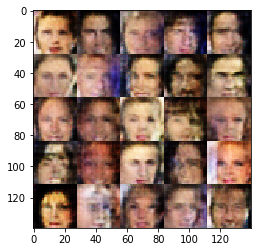

Epoch 1/1... Discriminator Loss: 2.0063... Generator Loss: 0.2615
Epoch 1/1... Discriminator Loss: 2.4331... Generator Loss: 0.1557
Epoch 1/1... Discriminator Loss: 2.1357... Generator Loss: 0.2166
Epoch 1/1... Discriminator Loss: 2.3759... Generator Loss: 0.1650
Epoch 1/1... Discriminator Loss: 2.3337... Generator Loss: 0.1855
Epoch 1/1... Discriminator Loss: 2.3832... Generator Loss: 0.1708
Epoch 1/1... Discriminator Loss: 2.7765... Generator Loss: 0.1004
Epoch 1/1... Discriminator Loss: 2.6538... Generator Loss: 0.1210
Epoch 1/1... Discriminator Loss: 2.5359... Generator Loss: 0.1318
Epoch 1/1... Discriminator Loss: 2.2870... Generator Loss: 0.1725


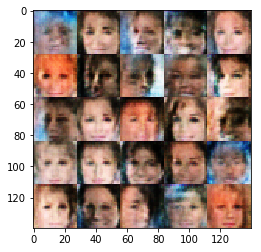

Epoch 1/1... Discriminator Loss: 2.3890... Generator Loss: 0.1688
Epoch 1/1... Discriminator Loss: 2.2891... Generator Loss: 0.1844
Epoch 1/1... Discriminator Loss: 2.2974... Generator Loss: 0.1819
Epoch 1/1... Discriminator Loss: 2.3956... Generator Loss: 0.1694
Epoch 1/1... Discriminator Loss: 2.0768... Generator Loss: 0.2141
Epoch 1/1... Discriminator Loss: 2.5660... Generator Loss: 0.1365
Epoch 1/1... Discriminator Loss: 2.1562... Generator Loss: 0.2029
Epoch 1/1... Discriminator Loss: 2.5202... Generator Loss: 0.1387
Epoch 1/1... Discriminator Loss: 2.6214... Generator Loss: 0.1181
Epoch 1/1... Discriminator Loss: 2.3683... Generator Loss: 0.1554


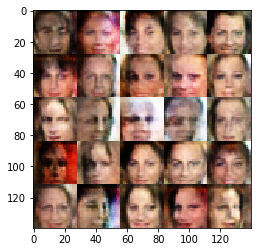

Epoch 1/1... Discriminator Loss: 2.2411... Generator Loss: 0.1922
Epoch 1/1... Discriminator Loss: 2.4376... Generator Loss: 0.1527
Epoch 1/1... Discriminator Loss: 2.1933... Generator Loss: 0.1905
Epoch 1/1... Discriminator Loss: 2.5120... Generator Loss: 0.1460
Epoch 1/1... Discriminator Loss: 2.2502... Generator Loss: 0.1896
Epoch 1/1... Discriminator Loss: 2.2967... Generator Loss: 0.1885
Epoch 1/1... Discriminator Loss: 2.1770... Generator Loss: 0.2102
Epoch 1/1... Discriminator Loss: 2.2489... Generator Loss: 0.2070
Epoch 1/1... Discriminator Loss: 2.0845... Generator Loss: 0.2263
Epoch 1/1... Discriminator Loss: 1.9944... Generator Loss: 0.2745


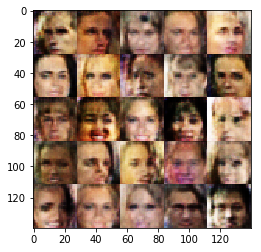

Epoch 1/1... Discriminator Loss: 2.4978... Generator Loss: 0.1657
Epoch 1/1... Discriminator Loss: 2.2057... Generator Loss: 0.2041
Epoch 1/1... Discriminator Loss: 2.0825... Generator Loss: 0.2259
Epoch 1/1... Discriminator Loss: 2.4998... Generator Loss: 0.1534
Epoch 1/1... Discriminator Loss: 2.4427... Generator Loss: 0.1534
Epoch 1/1... Discriminator Loss: 2.8496... Generator Loss: 0.1050
Epoch 1/1... Discriminator Loss: 2.0322... Generator Loss: 0.2362
Epoch 1/1... Discriminator Loss: 2.3982... Generator Loss: 0.1543
Epoch 1/1... Discriminator Loss: 2.6454... Generator Loss: 0.1200
Epoch 1/1... Discriminator Loss: 2.0601... Generator Loss: 0.2356


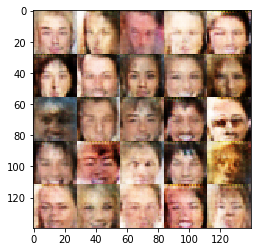

Epoch 1/1... Discriminator Loss: 2.6469... Generator Loss: 0.1154
Epoch 1/1... Discriminator Loss: 2.5132... Generator Loss: 0.1452
Epoch 1/1... Discriminator Loss: 2.3368... Generator Loss: 0.1782
Epoch 1/1... Discriminator Loss: 2.4647... Generator Loss: 0.1471
Epoch 1/1... Discriminator Loss: 2.7191... Generator Loss: 0.1195
Epoch 1/1... Discriminator Loss: 2.0224... Generator Loss: 0.2537
Epoch 1/1... Discriminator Loss: 2.3781... Generator Loss: 0.1640
Epoch 1/1... Discriminator Loss: 2.5144... Generator Loss: 0.1349
Epoch 1/1... Discriminator Loss: 2.4558... Generator Loss: 0.1461
Epoch 1/1... Discriminator Loss: 2.3890... Generator Loss: 0.1600


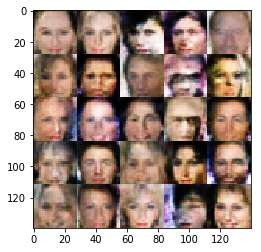

Epoch 1/1... Discriminator Loss: 2.4086... Generator Loss: 0.1692
Epoch 1/1... Discriminator Loss: 2.7027... Generator Loss: 0.1169
Epoch 1/1... Discriminator Loss: 2.7431... Generator Loss: 0.1114
Epoch 1/1... Discriminator Loss: 2.6344... Generator Loss: 0.1179
Epoch 1/1... Discriminator Loss: 2.4494... Generator Loss: 0.1475
Epoch 1/1... Discriminator Loss: 2.4877... Generator Loss: 0.1348
Epoch 1/1... Discriminator Loss: 2.2691... Generator Loss: 0.1752
Epoch 1/1... Discriminator Loss: 2.0854... Generator Loss: 0.2328
Epoch 1/1... Discriminator Loss: 2.4906... Generator Loss: 0.1370
Epoch 1/1... Discriminator Loss: 2.2969... Generator Loss: 0.1759


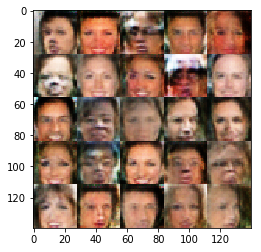

Epoch 1/1... Discriminator Loss: 2.3012... Generator Loss: 0.1857
Epoch 1/1... Discriminator Loss: 2.0835... Generator Loss: 0.2291
Epoch 1/1... Discriminator Loss: 2.2562... Generator Loss: 0.1964
Epoch 1/1... Discriminator Loss: 2.3818... Generator Loss: 0.1534
Epoch 1/1... Discriminator Loss: 2.0619... Generator Loss: 0.2355
Epoch 1/1... Discriminator Loss: 2.2198... Generator Loss: 0.1865
Epoch 1/1... Discriminator Loss: 2.3926... Generator Loss: 0.1823
Epoch 1/1... Discriminator Loss: 2.6401... Generator Loss: 0.1379
Epoch 1/1... Discriminator Loss: 2.1972... Generator Loss: 0.1830
Epoch 1/1... Discriminator Loss: 2.1892... Generator Loss: 0.1985


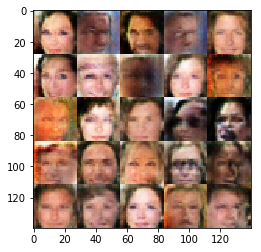

Epoch 1/1... Discriminator Loss: 2.5228... Generator Loss: 0.1382
Epoch 1/1... Discriminator Loss: 2.1695... Generator Loss: 0.2214
Epoch 1/1... Discriminator Loss: 2.0018... Generator Loss: 0.2452
Epoch 1/1... Discriminator Loss: 2.4742... Generator Loss: 0.1448
Epoch 1/1... Discriminator Loss: 2.1753... Generator Loss: 0.2085
Epoch 1/1... Discriminator Loss: 2.1824... Generator Loss: 0.1960
Epoch 1/1... Discriminator Loss: 2.4537... Generator Loss: 0.1475
Epoch 1/1... Discriminator Loss: 2.1608... Generator Loss: 0.2188
Epoch 1/1... Discriminator Loss: 2.2892... Generator Loss: 0.1928
Epoch 1/1... Discriminator Loss: 2.3413... Generator Loss: 0.1754


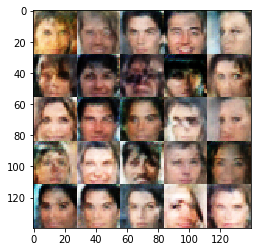

Epoch 1/1... Discriminator Loss: 2.2820... Generator Loss: 0.1645
Epoch 1/1... Discriminator Loss: 2.3301... Generator Loss: 0.1860
Epoch 1/1... Discriminator Loss: 2.1589... Generator Loss: 0.2090
Epoch 1/1... Discriminator Loss: 2.2886... Generator Loss: 0.1775
Epoch 1/1... Discriminator Loss: 2.3069... Generator Loss: 0.1872
Epoch 1/1... Discriminator Loss: 1.9233... Generator Loss: 0.2747
Epoch 1/1... Discriminator Loss: 2.3814... Generator Loss: 0.1746
Epoch 1/1... Discriminator Loss: 2.2343... Generator Loss: 0.1943
Epoch 1/1... Discriminator Loss: 2.4061... Generator Loss: 0.1525
Epoch 1/1... Discriminator Loss: 2.4373... Generator Loss: 0.1512


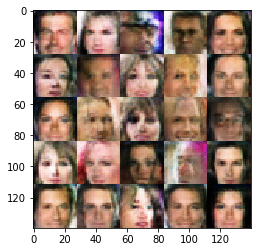

Epoch 1/1... Discriminator Loss: 2.1496... Generator Loss: 0.2048
Epoch 1/1... Discriminator Loss: 2.0361... Generator Loss: 0.2393
Epoch 1/1... Discriminator Loss: 2.2778... Generator Loss: 0.1855
Epoch 1/1... Discriminator Loss: 2.1491... Generator Loss: 0.2217
Epoch 1/1... Discriminator Loss: 2.4270... Generator Loss: 0.1530
Epoch 1/1... Discriminator Loss: 2.4440... Generator Loss: 0.1689
Epoch 1/1... Discriminator Loss: 1.9203... Generator Loss: 0.2642
Epoch 1/1... Discriminator Loss: 2.4012... Generator Loss: 0.1567
Epoch 1/1... Discriminator Loss: 2.0282... Generator Loss: 0.2551
Epoch 1/1... Discriminator Loss: 2.1808... Generator Loss: 0.2145


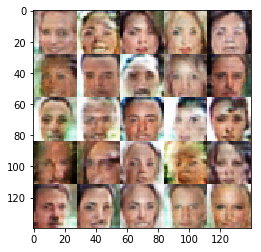

Epoch 1/1... Discriminator Loss: 2.4831... Generator Loss: 0.1400
Epoch 1/1... Discriminator Loss: 2.2816... Generator Loss: 0.1848
Epoch 1/1... Discriminator Loss: 2.3096... Generator Loss: 0.1674
Epoch 1/1... Discriminator Loss: 2.5148... Generator Loss: 0.1446
Epoch 1/1... Discriminator Loss: 2.1700... Generator Loss: 0.2072
Epoch 1/1... Discriminator Loss: 2.4245... Generator Loss: 0.1648
Epoch 1/1... Discriminator Loss: 2.0749... Generator Loss: 0.2144
Epoch 1/1... Discriminator Loss: 2.2080... Generator Loss: 0.1978
Epoch 1/1... Discriminator Loss: 1.9834... Generator Loss: 0.2596
Epoch 1/1... Discriminator Loss: 1.9284... Generator Loss: 0.2605


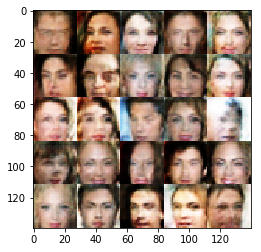

Epoch 1/1... Discriminator Loss: 2.2202... Generator Loss: 0.1864
Epoch 1/1... Discriminator Loss: 1.9264... Generator Loss: 0.2577
Epoch 1/1... Discriminator Loss: 2.3265... Generator Loss: 0.1720
Epoch 1/1... Discriminator Loss: 2.3103... Generator Loss: 0.1656
Epoch 1/1... Discriminator Loss: 2.2413... Generator Loss: 0.1846
Epoch 1/1... Discriminator Loss: 2.2580... Generator Loss: 0.1959
Epoch 1/1... Discriminator Loss: 2.3683... Generator Loss: 0.1634
Epoch 1/1... Discriminator Loss: 2.3498... Generator Loss: 0.1871
Epoch 1/1... Discriminator Loss: 2.2295... Generator Loss: 0.1970
Epoch 1/1... Discriminator Loss: 2.3455... Generator Loss: 0.1738


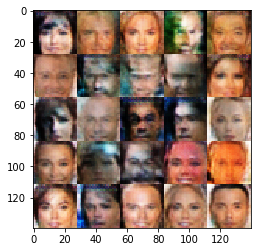

Epoch 1/1... Discriminator Loss: 2.0236... Generator Loss: 0.2464
Epoch 1/1... Discriminator Loss: 2.4563... Generator Loss: 0.1689
Epoch 1/1... Discriminator Loss: 2.0532... Generator Loss: 0.2360
Epoch 1/1... Discriminator Loss: 2.3806... Generator Loss: 0.1647
Epoch 1/1... Discriminator Loss: 2.1357... Generator Loss: 0.2425
Epoch 1/1... Discriminator Loss: 2.0669... Generator Loss: 0.2203
Epoch 1/1... Discriminator Loss: 2.2231... Generator Loss: 0.1939
Epoch 1/1... Discriminator Loss: 2.2261... Generator Loss: 0.2171
Epoch 1/1... Discriminator Loss: 2.3198... Generator Loss: 0.1661
Epoch 1/1... Discriminator Loss: 2.5006... Generator Loss: 0.1514


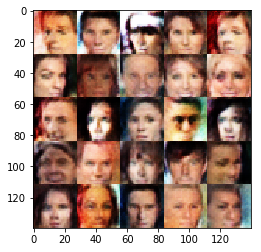

Epoch 1/1... Discriminator Loss: 2.3132... Generator Loss: 0.1702
Epoch 1/1... Discriminator Loss: 2.3570... Generator Loss: 0.1705
Epoch 1/1... Discriminator Loss: 2.4177... Generator Loss: 0.1445
Epoch 1/1... Discriminator Loss: 2.0516... Generator Loss: 0.2193
Epoch 1/1... Discriminator Loss: 2.2853... Generator Loss: 0.1652
Epoch 1/1... Discriminator Loss: 2.1572... Generator Loss: 0.2059
Epoch 1/1... Discriminator Loss: 2.2830... Generator Loss: 0.1772
Epoch 1/1... Discriminator Loss: 2.2737... Generator Loss: 0.1849
Epoch 1/1... Discriminator Loss: 2.2072... Generator Loss: 0.2046
Epoch 1/1... Discriminator Loss: 2.1462... Generator Loss: 0.2084


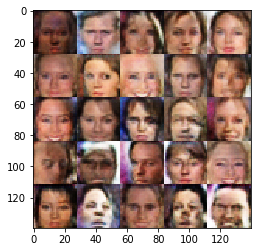

Epoch 1/1... Discriminator Loss: 2.2297... Generator Loss: 0.1850
Epoch 1/1... Discriminator Loss: 2.2636... Generator Loss: 0.1919
Epoch 1/1... Discriminator Loss: 2.2296... Generator Loss: 0.1951
Epoch 1/1... Discriminator Loss: 1.9394... Generator Loss: 0.2721
Epoch 1/1... Discriminator Loss: 2.2172... Generator Loss: 0.1994
Epoch 1/1... Discriminator Loss: 2.0390... Generator Loss: 0.2449
Epoch 1/1... Discriminator Loss: 2.3480... Generator Loss: 0.1710
Epoch 1/1... Discriminator Loss: 2.1800... Generator Loss: 0.2010
Epoch 1/1... Discriminator Loss: 2.3691... Generator Loss: 0.1815
Epoch 1/1... Discriminator Loss: 2.4174... Generator Loss: 0.1520


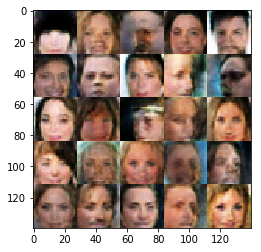

Epoch 1/1... Discriminator Loss: 2.2556... Generator Loss: 0.1866
Epoch 1/1... Discriminator Loss: 2.2987... Generator Loss: 0.1764
Epoch 1/1... Discriminator Loss: 2.4604... Generator Loss: 0.1448
Epoch 1/1... Discriminator Loss: 1.9491... Generator Loss: 0.2501
Epoch 1/1... Discriminator Loss: 2.3994... Generator Loss: 0.1543
Epoch 1/1... Discriminator Loss: 2.2080... Generator Loss: 0.1992
Epoch 1/1... Discriminator Loss: 2.0934... Generator Loss: 0.2294
Epoch 1/1... Discriminator Loss: 2.0065... Generator Loss: 0.2355
Epoch 1/1... Discriminator Loss: 2.4331... Generator Loss: 0.1436
Epoch 1/1... Discriminator Loss: 2.4253... Generator Loss: 0.1588


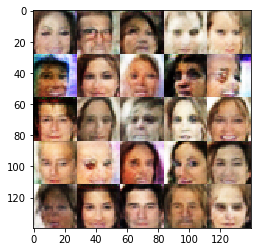

Epoch 1/1... Discriminator Loss: 2.0363... Generator Loss: 0.2254
Epoch 1/1... Discriminator Loss: 2.4547... Generator Loss: 0.1539
Epoch 1/1... Discriminator Loss: 2.2469... Generator Loss: 0.1826
Epoch 1/1... Discriminator Loss: 2.5228... Generator Loss: 0.1307
Epoch 1/1... Discriminator Loss: 2.3641... Generator Loss: 0.1663
Epoch 1/1... Discriminator Loss: 2.6192... Generator Loss: 0.1267
Epoch 1/1... Discriminator Loss: 2.1334... Generator Loss: 0.2175
Epoch 1/1... Discriminator Loss: 2.3028... Generator Loss: 0.1712
Epoch 1/1... Discriminator Loss: 2.1866... Generator Loss: 0.1883
Epoch 1/1... Discriminator Loss: 2.3126... Generator Loss: 0.1956


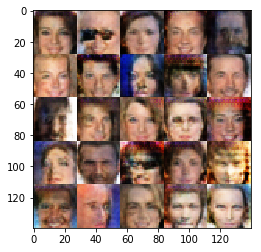

Epoch 1/1... Discriminator Loss: 2.2054... Generator Loss: 0.1903
Epoch 1/1... Discriminator Loss: 2.2592... Generator Loss: 0.1813
Epoch 1/1... Discriminator Loss: 2.0622... Generator Loss: 0.2318
Epoch 1/1... Discriminator Loss: 2.3282... Generator Loss: 0.1692
Epoch 1/1... Discriminator Loss: 2.1892... Generator Loss: 0.1969
Epoch 1/1... Discriminator Loss: 2.5312... Generator Loss: 0.1361
Epoch 1/1... Discriminator Loss: 2.4760... Generator Loss: 0.1493
Epoch 1/1... Discriminator Loss: 2.3217... Generator Loss: 0.1763
Epoch 1/1... Discriminator Loss: 2.4041... Generator Loss: 0.1585
Epoch 1/1... Discriminator Loss: 2.2761... Generator Loss: 0.1698


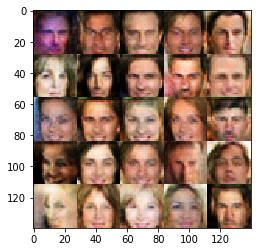

Epoch 1/1... Discriminator Loss: 1.8494... Generator Loss: 0.2800
Epoch 1/1... Discriminator Loss: 2.5092... Generator Loss: 0.1364
Epoch 1/1... Discriminator Loss: 1.8717... Generator Loss: 0.2860
Epoch 1/1... Discriminator Loss: 2.3409... Generator Loss: 0.1570
Epoch 1/1... Discriminator Loss: 2.3586... Generator Loss: 0.1695
Epoch 1/1... Discriminator Loss: 2.3649... Generator Loss: 0.1630
Epoch 1/1... Discriminator Loss: 2.2659... Generator Loss: 0.1810
Epoch 1/1... Discriminator Loss: 2.2953... Generator Loss: 0.1698
Epoch 1/1... Discriminator Loss: 2.4129... Generator Loss: 0.1492
Epoch 1/1... Discriminator Loss: 2.1093... Generator Loss: 0.2120


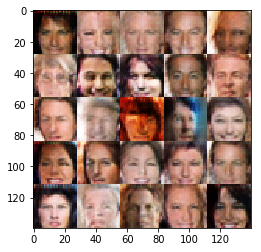

Epoch 1/1... Discriminator Loss: 2.1724... Generator Loss: 0.1899
Epoch 1/1... Discriminator Loss: 2.3946... Generator Loss: 0.1606
Epoch 1/1... Discriminator Loss: 2.1943... Generator Loss: 0.2009
Epoch 1/1... Discriminator Loss: 2.5047... Generator Loss: 0.1315
Epoch 1/1... Discriminator Loss: 2.3062... Generator Loss: 0.1714
Epoch 1/1... Discriminator Loss: 2.2909... Generator Loss: 0.1662
Epoch 1/1... Discriminator Loss: 2.2379... Generator Loss: 0.1879
Epoch 1/1... Discriminator Loss: 2.2954... Generator Loss: 0.1852
Epoch 1/1... Discriminator Loss: 2.2568... Generator Loss: 0.1976
Epoch 1/1... Discriminator Loss: 2.0211... Generator Loss: 0.2298


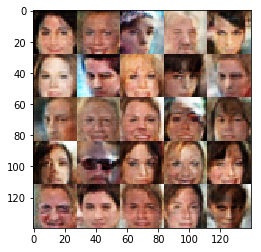

Epoch 1/1... Discriminator Loss: 2.1945... Generator Loss: 0.1976
Epoch 1/1... Discriminator Loss: 2.2855... Generator Loss: 0.1806
Epoch 1/1... Discriminator Loss: 2.0908... Generator Loss: 0.2195
Epoch 1/1... Discriminator Loss: 2.1748... Generator Loss: 0.1981
Epoch 1/1... Discriminator Loss: 2.2868... Generator Loss: 0.1648
Epoch 1/1... Discriminator Loss: 2.3848... Generator Loss: 0.1615
Epoch 1/1... Discriminator Loss: 2.3545... Generator Loss: 0.1626
Epoch 1/1... Discriminator Loss: 2.3233... Generator Loss: 0.1668
Epoch 1/1... Discriminator Loss: 2.3276... Generator Loss: 0.1698
Epoch 1/1... Discriminator Loss: 2.2626... Generator Loss: 0.1799


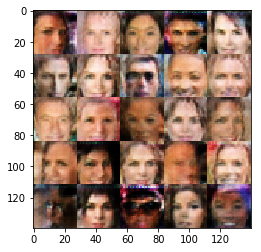

Epoch 1/1... Discriminator Loss: 2.3511... Generator Loss: 0.1534
Epoch 1/1... Discriminator Loss: 2.1995... Generator Loss: 0.1917
Epoch 1/1... Discriminator Loss: 2.3336... Generator Loss: 0.1634
Epoch 1/1... Discriminator Loss: 2.3447... Generator Loss: 0.1583
Epoch 1/1... Discriminator Loss: 2.2748... Generator Loss: 0.1808
Epoch 1/1... Discriminator Loss: 2.0652... Generator Loss: 0.2296
Epoch 1/1... Discriminator Loss: 2.1529... Generator Loss: 0.2223
Epoch 1/1... Discriminator Loss: 2.5561... Generator Loss: 0.1389
Epoch 1/1... Discriminator Loss: 2.2431... Generator Loss: 0.1852
Epoch 1/1... Discriminator Loss: 2.3299... Generator Loss: 0.1688


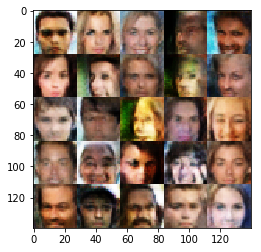

Epoch 1/1... Discriminator Loss: 2.2592... Generator Loss: 0.2129
Epoch 1/1... Discriminator Loss: 1.9490... Generator Loss: 0.2354
Epoch 1/1... Discriminator Loss: 2.1136... Generator Loss: 0.2087
Epoch 1/1... Discriminator Loss: 2.1608... Generator Loss: 0.1947
Epoch 1/1... Discriminator Loss: 2.1473... Generator Loss: 0.1944
Epoch 1/1... Discriminator Loss: 2.1302... Generator Loss: 0.2093
Epoch 1/1... Discriminator Loss: 2.1831... Generator Loss: 0.2030
Epoch 1/1... Discriminator Loss: 2.5239... Generator Loss: 0.1417
Epoch 1/1... Discriminator Loss: 2.1739... Generator Loss: 0.2096
Epoch 1/1... Discriminator Loss: 2.3096... Generator Loss: 0.1653


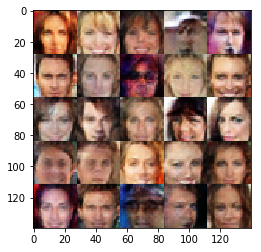

Epoch 1/1... Discriminator Loss: 2.4721... Generator Loss: 0.1413
Epoch 1/1... Discriminator Loss: 2.2565... Generator Loss: 0.1685
Epoch 1/1... Discriminator Loss: 2.3203... Generator Loss: 0.1657
Epoch 1/1... Discriminator Loss: 2.3298... Generator Loss: 0.1832
Epoch 1/1... Discriminator Loss: 2.2469... Generator Loss: 0.1821
Epoch 1/1... Discriminator Loss: 2.1576... Generator Loss: 0.1969


In [13]:
batch_size = 64
z_dim = 128
learning_rate = .0004
beta1 = .5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.